In [1]:
%matplotlib inline

import sys
sys.path.append("..") # This allows for importing from other directories above
# Our imports
from models.adaboost_mh import AdaBoostMH
from models.weak_learner import stump_base as weak_clf
# Standard Imports
import numpy as np
import matplotlib.pyplot as plt


# Load the data
switch = 3
if switch == 0:
    X_train = np.load('../data/pendigits/pendigits_train_data.npy')
    y_train = np.load('../data/pendigits/pendigits_train_labels.npy')
    X_test = np.load('../data/pendigits/pendigits_test_data.npy')
    y_test = np.load('../data/pendigits/pendigits_test_labels.npy')
    k = 10
elif switch == 1:
    X_train = np.load('../data/synth/synth_train_data.npy')
    y_train = np.load('../data/synth/synth_train_labels.npy')
    X_test = np.load('../data/synth/synth_test_data.npy')
    y_test = np.load('../data/synth/synth_test_labels.npy')
    k = 10
elif switch == 2:
    X_train = np.load('../data/synthBinary/synthBinary_train_data.npy')
    y_train = np.load('../data/synthBinary/synthBinary_train_labels.npy')
    X_test = np.load('../data/synthBinary/synthBinary_test_data.npy')
    y_test = np.load('../data/synthBinary/synthBinary_test_labels.npy')
    k = 2
else:
    X_train = np.load('../data/synthTernary/synthTernary_train_data.npy')
    y_train = np.load('../data/synthTernary/synthTernary_train_labels.npy')
    X_test = np.load('../data/synthTernary/synthTernary_test_data.npy')
    y_test = np.load('../data/synthTernary/synthTernary_test_labels.npy')
    k = 3

y_train = y_train[0:6]
X_train = X_train[0:6]
    
# Initialize model 
model = AdaBoostMH(X_train, y_train, X_test, y_test, 0.5)

In [2]:
T = 10
verbose = 2
err_tr, err_te, gams, v_ts, d_ts = model.run_factorized(T, weak_clf, 'unif', verbose)

Round 1
alpha is 0.34657359027997264
Edge is 0.3333333333333333
Energy is 0.9428090415820634
v is [-1. -1. -1.]
b is -inf
 col is 0
Round 2
alpha is 0.34657359027997264
Edge is 0.3333333333333333
Energy is 0.9428090415820635
v is [-1.  1.  1.]
b is 0.5
 col is 0
Round 3
alpha is 0.394228680182135
Edge is 0.37500000000000006
Energy is 0.9270248108869579
v is [-1. -1.  1.]
b is 4.5
 col is 0
Round 4
alpha is 0.3602730773740297
Edge is 0.34545454545454546
Energy is 0.9384354836773775
v is [-1. -1.  1.]
b is 1.5
 col is 0
Round 5
alpha is 0.39030324294426566
Edge is 0.37162162162162143
Energy is 0.9283842794572279
v is [ 1.  1. -1.]
b is 2.5
 col is 0
Round 6
alpha is 0.4352999058858867
Edge is 0.4097409820435405
Energy is 0.9122019116588141
v is [-1.  1.  1.]
b is 3.5
 col is 0
Round 7
alpha is 0.40390739260321107
Edge is 0.38328730579195547
Energy is 0.9236291686703836
v is [ 1. -1. -1.]
b is 2.5
 col is 0
Round 8
alpha is 0.3531928808289539
Edge is 0.3392041079578934
Energy is 0.9407128

In [3]:
print(err_tr)

0.0


In [4]:
print(err_te)

0.35555555555555557


In [5]:
len(d_ts)

11

In [6]:
# One hot encode 
def one_hot_labels(y,k):
    """
    y: N by 1 numpy-array corresponding to the labels.
    k: float, corresponding to number of unique classes.
    returns: Y, an N by k numpy-array with each row containing
             a 1 for the correct class and -1 otherwise.
    """
    N = y.shape[0]
    Y = np.ones((N, k)) * -1
    for i in range(N):
        Y[i, y[i]] *= -1 # Make the correct class become +1.
    return Y

In [7]:
Y_one_hot = one_hot_labels(y_train, k)

In [8]:
def calc_pseudo_ws(Wts, vts, Y, T):
    w_pseudo_ts = []
    for t in range(T):
        W_t = Wts[t + 1] # skip W_0
        v_t = vts[t] 
        # Get all the y_i,l * v_l in one matrix
        Y_mult_v_t = np.multiply(Y, v_t)
        # The above is either 1 or -1, to get an indicator
        # about whether their product is +1 or -1 you can 
        # add one to the whole matrix and all the -1 -> 0,
        # or add negative one to the whole matrix and all
        # the +1 -> 0. You just need to normalize by \pm 1/2,
        # to get an indicator or a matrix mask.
        w_p_mask = ((Y_mult_v_t + 1) * 0.5).astype('int')
        w_n_mask = ((Y_mult_v_t - 1) * -0.5).astype('int')
        w_p_t = np.sum(np.multiply(W_t, w_p_mask), axis=1)
        w_n_t = np.sum(np.multiply(W_t, w_n_mask), axis=1)
        w_pseudo_t = np.sum(np.abs(w_p_t - w_n_t))
        w_pseudo_ts.append(w_pseudo_t)
    return w_pseudo_ts

In [9]:
pseudo_W_ts = calc_pseudo_ws(d_ts, v_ts, Y_one_hot, T)

In [10]:
pseudo_W_ts

[0.0,
 0.5000000000000001,
 0.5000000000000001,
 0.5405405405405405,
 0.42239172272542697,
 0.5767094378377701,
 0.49595890980296675,
 0.4786129751375228,
 0.8000372760375891,
 0.7592939998558178]

In [11]:
# Function for plotting Pseudo weights on same plot for two datasets
def plot_ws(pseudo_W_s, T, title):
    ts = np.linspace(1, T, num=T)
    plt.plot(ts, pseudo_W_s, label='Pseudo Weights')
    plt.legend(loc='best')
    plt.xlabel("T")
    plt.ylabel("Pseudo Weight Value")
    plt.title(title)

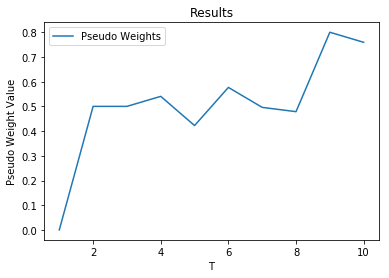

In [12]:
plot_ws(pseudo_W_ts, T, "Results")

In [13]:
np.min(pseudo_W_ts)

0.0